In [35]:
import pandas as pd
import numpy as np
import pdb
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from itertools import product

df = pd.read_csv('structure.csv')

n = 10 # This is the assumed sampling number
# wは制御因子, xは誤差因子
x_labels = [c for c in df.columns if 'x' in c]
w_u_labels = [c for c in df.columns if 'w' in c]
w_u_labels_dict = {}
for w_u_label in w_u_labels:
    w = w_u_label.split(':')[0]
    u = w_u_label.split(':')[1]
    if not w in w_u_labels_dict:
        w_u_labels_dict[w] = [u]
    else:
        w_u_labels_dict[w].append(u)
df_error = df[w_u_labels]
df_control = df[x_labels]
N = len(df) # 8
N_x = len(x_labels)
N_w = len(w_labels)


In [36]:
df_error

,w1:u1,w1:u2,w2:u1,w2:u2
0,15.93,-10.84,25.40,-6.66
1,16.61,-12.59,24.92,-4.57
2,17.32,-13.96,24.04,-7.24
3,15.72,-12.17,22.82,-5.06
4,16.37,-13.20,22.71,-6.86
5,16.88,-13.44,23.77,-6.56
6,15.38,-12.26,21.60,-6.04
7,16.40,-13.35,22.51,-7.24
8,17.01,-14.09,22.84,-8.26
9,16.82,-12.57,25.32,-4.07


In [40]:
beta = [0]*N
for i, row in df_error.iterrows():
    print(row)

w1:u1    15.93
w1:u2   -10.84
w2:u1    25.40
w2:u2    -6.66
Name: 0, dtype: float64
w1:u1    16.61
w1:u2   -12.59
w2:u1    24.92
w2:u2    -4.57
Name: 1, dtype: float64
w1:u1    17.32
w1:u2   -13.96
w2:u1    24.04
w2:u2    -7.24
Name: 2, dtype: float64
w1:u1    15.72
w1:u2   -12.17
w2:u1    22.82
w2:u2    -5.06
Name: 3, dtype: float64
w1:u1    16.37
w1:u2   -13.20
w2:u1    22.71
w2:u2    -6.86
Name: 4, dtype: float64
w1:u1    16.88
w1:u2   -13.44
w2:u1    23.77
w2:u2    -6.56
Name: 5, dtype: float64
w1:u1    15.38
w1:u2   -12.26
w2:u1    21.60
w2:u2    -6.04
Name: 6, dtype: float64
w1:u1    16.40
w1:u2   -13.35
w2:u1    22.51
w2:u2    -7.24
Name: 7, dtype: float64
w1:u1    17.01
w1:u2   -14.09
w2:u1    22.84
w2:u2    -8.26
Name: 8, dtype: float64
w1:u1    16.82
w1:u2   -12.57
w2:u1    25.32
w2:u2    -4.07
Name: 9, dtype: float64
w1:u1    16.05
w1:u2   -12.19
w2:u1    23.02
w2:u2    -4.44
Name: 10, dtype: float64
w1:u1    17.21
w1:u2   -12.94
w2:u1    27.23
w2:u2    -4.40
Name: 11, dtype

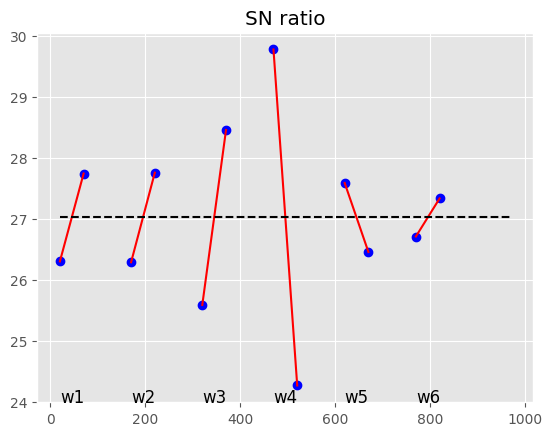

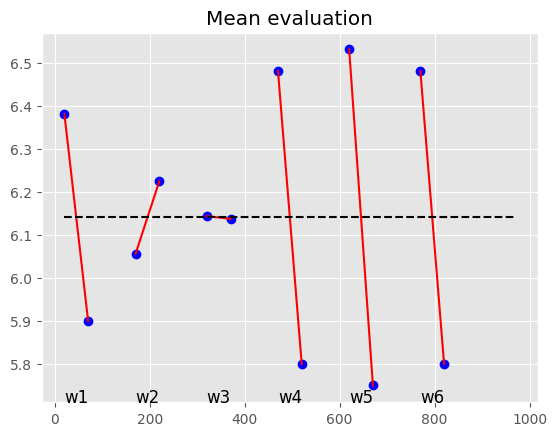

[ 0.48125 -0.16875  0.00625  0.68125  0.78125  0.68125]
4.909374999999999
**********************
Optimal solution
**********************
X1    1.000000
X2    0.000000
X3    1.000000
X4    1.000000
X5    1.000000
X6    1.000000
Y     7.540625
Name: 47, dtype: float64


/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [18]:
SN = [0]*N
beta = [0]*N
for i, row in df_error.iterrows():
    #感度β(回帰直線の傾き)の計算 
    

    
    #望目特性のSN比の公式
    SN[i] = 10*math.log10(row.mean()**2/row.var()-1/n)
    #望大特性のSN比の公式(非推奨)
    #SN[i] = -10*math.log10(1/n*sum([1/x**2 for x in row]))
    #望大特性・望小特性の計算式は分母に分散（ばらつき）の情報が入っていないので、
    #1段階目のパラメータ選択に使うSN比としての意義がないかもしれない。　
    #参考: https://seinzumtode.hatenadiary.jp/entry/2024/09/06/152834

# 改善すべき因子の抽出 (第一段階: SN比を利用)
SN_mean_difference = [0]*N_w
sn_mean_a = [0]*N_w
sn_mean_b = [0]*N_w
for i in range(N_w):
    w = w_labels[i]
    df_w = df_control[w]
    for j, sn in enumerate(SN):
        if df_w[j]==1:
            sn_mean_a[i] += SN[j]
        else:
            sn_mean_b[i] += SN[j]
    sn_mean_a[i] = sn_mean_a[i] / (N/2)
    sn_mean_b[i] = sn_mean_b[i] / (N/2)
    SN_mean_difference[i] = sn_mean_a[i] - sn_mean_b[i]
    
# 目標値のあわせこみ(第二段階: 平均値を利用)
Mean = df_error.mean(axis=1).tolist()
Mean_mean_difference = [0]*N_w
mean_mean_a = [0]*N_w
mean_mean_b = [0]*N_w
for i in range(N_w):
    w = w_labels[i]
    df_w = df_control[w]
    for j, sn in enumerate(Mean):
        if df_w[j]==1:
            mean_mean_a[i] += Mean[j]
        else:
            mean_mean_b[i] += Mean[j]
    mean_mean_a[i] = mean_mean_a[i] / (N/2)
    mean_mean_b[i] = mean_mean_b[i] / (N/2)
    Mean_mean_difference[i] = mean_mean_a[i] - mean_mean_b[i]

# 要因効果図の描画
offset = 150
initial_x = 20
width = 50
x_a = [initial_x]
x_b = [initial_x+width]
# x座標生成
for i in range(N_w):
    x_a.append(x_a[-1]+offset)
    x_b.append(x_b[-1]+offset)

plt.figure(1)
plt.title("SN ratio")
plt.figure(2)
plt.title("Mean evaluation")

# 要因効果図の描画
for i in range(N_w):
    sn_a = sn_mean_a[i]
    sn_b = sn_mean_b[i]
    plt.figure(1)
    plt.plot(x_a[i],sn_a,'bo')
    plt.plot(x_b[i],sn_b,'bo')
    plt.plot((x_a[i],x_b[i]),(sn_a,sn_b),'r')

    mean_a = mean_mean_a[i]
    mean_b = mean_mean_b[i]
    plt.figure(2)
    plt.plot(x_a[i],mean_a,'bo')
    plt.plot(x_b[i],mean_b,'bo')
    plt.plot((x_a[i],x_b[i]),(mean_a,mean_b),'r')

# 平均値の描画
sn_average = pd.DataFrame(SN).mean()
mean_average = pd.DataFrame(Mean).mean()
plt.figure(1)
plt.plot((x_a[0],x_b[-1]),(sn_average,sn_average),'k--')
plt.figure(2)
plt.plot((x_a[0],x_b[-1]),(mean_average,mean_average),'k--')

# ラベルの描画
for i in range(N_w):
    plt.figure(1)
    axes = plt.gca()
    yl = axes.get_ylim()[0]
    plt.text(x_a[i], yl, 'w'+str(i+1), fontsize=12)

    plt.figure(2)
    axes = plt.gca()
    yl = axes.get_ylim()[0]
    plt.text(x_a[i], yl, 'w'+str(i+1), fontsize=12)

plt.show(block=False)

# パラメータの最適化(重回帰分析)
model = linear_model.LinearRegression()
Y = df_error.mean(axis=1)
X = df_control
model.fit(X,Y)
print(model.coef_)
print(model.intercept_)

# combi = [p for p in product((0,1),(0,1),(0,1),(0,1),(0,1),(0,1))]
patterns = list(product((0,1),(0,1),(0,1),(0,1),(0,1),(0,1)))
x = np.array(patterns)
y = model.predict(x)
y = y.reshape(len(y),1)
complete = np.hstack((x,y))
df_complete = pd.DataFrame(complete,columns=('X1','X2','X3','X4','X5','X6','Y'))
df_complete = df_complete.sort_values(by=['Y'],ascending=False)
print('**********************')
print('Optimal solution')
print('**********************')
print(df_complete.iloc[0])


#input("Press Enter to exit.")
